## Model 7 (BEST) Transfer Learning on ResNet50
Let's get our hands dirty and try to do transfer learning on ResNet50.

This notebook goes through the following steps to create a new model based on ResNet50 and tweaked to output predictions on our 10 classes:  

- Load ResNet50 model from keras without the deep learning layers
- Freeze the weights on all the layers except the last convolution block (142 layers untrainable, the last convolution block trainable). This way the model can use the last block to capture details related to our 10 dataset classes.
- Add 3 Dense layers to extract high-level features into the final predictions, plus the softmax classification dense layer at the end.
- Add a Lambda layer as model input, to perform image resizing on the fly.




## Load modules

In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.image import resize

import helpers
import importlib
importlib.reload(helpers)

from datetime import datetime
def timestamp():
    return datetime.now().strftime('%y%m%d_%H%M')

## Load dataset

In [2]:
# Load CIFAR-10 dataset
x_train, y_train, x_test, y_test = helpers.load_dataset(model='ResNet50')

# augmentate data
datagen = helpers.data_augmentation(x_train)



Loading CIFAR10 dataset
170498071/170498071 [==============================] - 2s 0us/step


## Model architecture

In [ ]:
# Load ResNet model pre-trained on ImageNet
resnet50_model = ResNet50(weights='imagenet', include_top=False)

# Freeze layers
for layer in resnet50_model.layers[:143]:
    layer.trainable = False

# Check the layer trainable state
for i, layer in enumerate(resnet50_model.layers):
    print(f"{i}. {layer.name}: {layer.trainable}")

print(resnet50_model.summary())
print(len(resnet50_model.layers))

# Create a new model on top of ResNet50
model = Sequential()
model.add(Lambda(lambda image: resize(image, (224, 224))))  # resize images
model.add(resnet50_model)

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

print(model.summary())



In [4]:
# Create callbacks
checkpoint = ModelCheckpoint(filepath=f'models/ckp/model7_{timestamp()}.keras', monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=RMSprop(learning_rate=1e-5), 
    metrics=['accuracy'])

# Train the model using the CIFAR-10 dataset
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    epochs=100, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

# save model
model_path = f"models/model7_{timestamp()}.keras"
model.save(model_path)

2024-09-27 05:10:07.856463: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Epoch 1/100


2024-09-27 05:10:18.267379: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4a54002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-27 05:10:18.267428: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-09-27 05:10:18.311026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727413818.416825     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 55s 29ms/step - loss: 2.0323 - accuracy: 0.3192 - val_loss: 0.7618 - val_accuracy: 0.8284
Epoch 2/100
1563/1563 [==============================] - 43s 27ms/step - loss: 1.3569 - accuracy: 0.5600 - val_loss: 0.5092 - val_accuracy: 0.8884
Epoch 3/100
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0605 - accuracy: 0.6821 - val_loss: 0.3771 - val_accuracy: 0.9112
Epoch 4/100
1563/1563 [==============================] - 42s 27ms/step - loss: 0.8765 - accuracy: 0.7569 - val_loss: 0.3121 - val_accuracy: 0.9237
Epoch 5/100
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7524 - accuracy: 0.8020 - val_loss: 0.2665 - val_accuracy: 0.9317
Epoch 6/100
1563/1563 [==============================] - 43s 27ms/step - loss: 0.6508 - accuracy: 0.8337 - val_loss: 0.2193 - val_accuracy: 0.9395
Epoch 7/100
1563/1563 [==============================] - 43s 27ms/step - loss: 0.5744 - accuracy: 0.8575 - val_loss: 0.2130 - val_

313/313 [==============================] - 6s 18ms/step
Model Loss: 0.17465724050998688
Model Accuracy: 0.9539999961853027
Precision: 0.9538942088933616
Recall: 0.954
F1-Score: 0.9539271507584923
Accuracy Score: 0.954


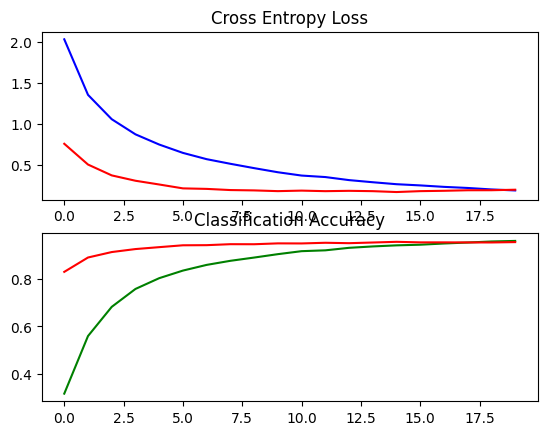

313/313 [==============================] - 5s 17ms/step


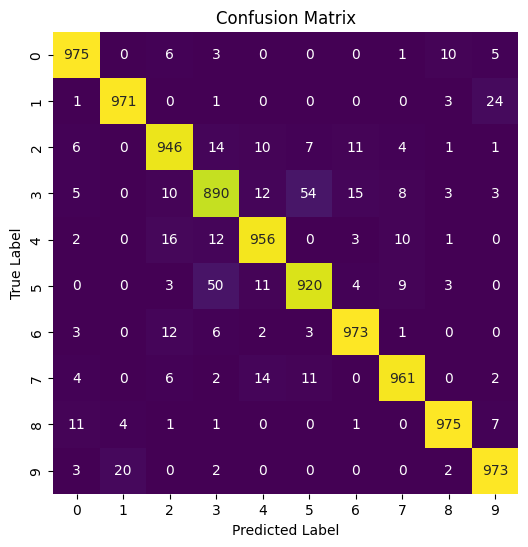

In [8]:
# plot results
helpers.evaluate_model(model, x_test, y_test)
helpers.plot_model_history(history)
helpers.plot_confusion_matrix(model, x_test, y_test)

In [3]:
# from keras.backend import clear_session
# clear_session()

## Conclusion
This is our best model so far. We built a new classifier that is using the weights from ResNet50. We trained the last convolution block, as well as our dense layers. The model's test accuracy reaches 95%, with minor misclassifications (mostly cats and dogs as before).

It is also impressive that only 20 epochs were required to reach this score. The RMSProp optimizer and the low learning rate are doing a good job at adapting the model to our dataset without breaking the initial weights.